In [2]:
########################################
#Nicholas Randall                      
#Code for Master Thesis 2017           
########################################
from scipy import signal, fftpack
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
from ipywidgets import widgets, interact
import pandas as pd
from sklearn import preprocessing
%matplotlib notebook
# for the first program see signal_filtering_0214

In [3]:
# This section of code reads the 
df = pd.read_csv('pmu_data.csv')
Phi=(df['V1VPM Angle']-df['I1XPM Angle'])
Real_Power=np.sqrt(3)*df['I1XPM Magnitude']*df['V1VPM Magnitude']*np.cos(np.radians(Phi))/(1e6)
Reactive_Power=np.sqrt(3)*df['I1XPM Magnitude']*df['V1VPM Magnitude']*np.sin(np.radians(Phi))/(1e6)
Apparent_Power=np.sqrt(np.power(Reactive_Power, 2)+np.power(Real_Power, 2))

<IPython.core.display.Javascript object>


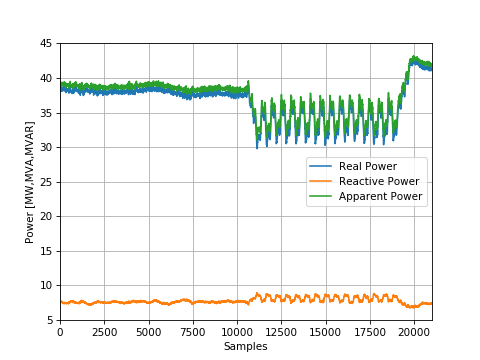

In [10]:
%matplotlib notebook
plt.figure()
plt_PowerR, =plt.plot(Real_Power, label='Real Power')
plt_Powerr, =plt.plot(Reactive_Power, label='Reactive Power')
plt_Apparent, =plt.plot(Apparent_Power, label='Apparent Power')
plt.legend([plt_PowerR, plt_Powerr, plt_Apparent], ['Real Power', 'Reactive Power', 'Apparent Power'],loc = 'best')
plt.xlabel('Samples')
plt.grid(True)
plt.ylabel('Power [MW,MVA,MVAR]')
plt.xlim(0,21000)
plt.show()
plt.savefig("figure1.pdf")

0.001
0.01


<IPython.core.display.Javascript object>


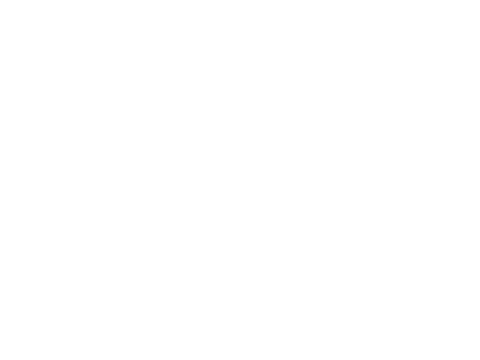

In [12]:
# Put data throuh a butterworth bandpass filter
nyq = 0.5 * 50
low =  0.025 / nyq
high = 0.25 / nyq
b, a = signal.butter(3, [low, high], btype='bandpass')
print(low)
print(high)
y = signal.lfilter(b, a, Real_Power)
plt.figure()
plt.grid(True)
plt.plot(y)

<IPython.core.display.Javascript object>


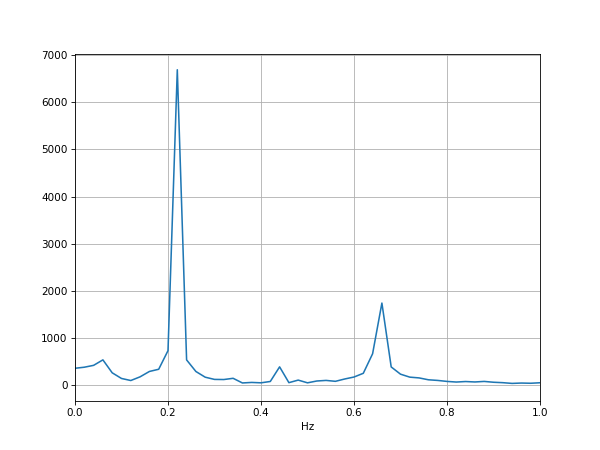

In [13]:
data = y[12000:18000]
z = fftpack.fft(data)
fft_out = np.absolute(z[:math.floor(len(z)/2)])[:200]
f = np.arange(0,4,.02)
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
plt.plot(f[:1000],fft_out[:1000])
axes = plt.gca()
#axes.set_ylim([0,30000])
axes.grid(True)
axes.set_xlim([0,1])
plt.xlabel('Hz')

In [7]:
def plot_things(index, window, max_hz):
#     f, t = signal.periodogram(df['I1XPM Magnitude'][index:index+window], nfft=frange, window='blackman')

    # Do fast fourier transform on filtered data
    z = fftpack.fft(y[index:index+window])
    # Get absolute values, cut out negative frequencies
    
    out = np.absolute(z)[:(max_hz*50)]
    f = np.arange(0,max_hz,.02)
    
    fig = plt.figure(figsize=(10,8))
    ax1 = fig.add_subplot(311)
    ax2 = fig.add_subplot(312)
    ax3 = fig.add_subplot(313)
    
    # RAw data
    ax1.plot(Real_Power[index:index+window])
    ax1.grid(True)
    # Filtered data
    ax2.plot(y[index:index+window]) 
    ax2.grid(True)
    # FFT
    ax3.plot(f,out)
    axes = plt.gca()
    axes.grid(True)
    #axes.set_ylim([0,4000])
    
    plt.tight_layout()
    
w=500
interact(plot_things, 
         index=(0,int(len(y)-w), 50),
         window = (50,2000,1),
         max_hz = (1,10,1))

<function __main__.plot_things>

In [8]:
# Identification loop

# Cut y
y = y[2500:]

thresh = 877
w = 1000
detector = np.zeros((len(y), 1))

for i in range(w, len(y)):
    z = fftpack.fft(y[i-w:i])
    out = np.absolute(z)[:25]

    
    if any(out > thresh):
        detector[i] = 1

<IPython.core.display.Javascript object>


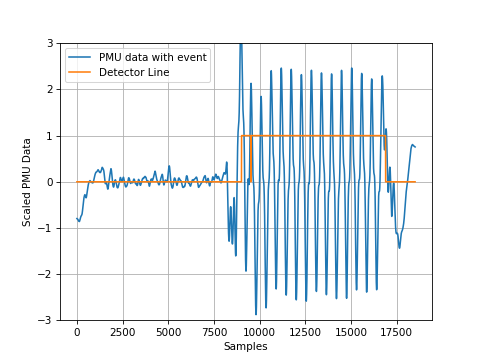

In [9]:
%matplotlib notebook
PMUData =plt.plot(preprocessing.scale(y),label ='PMU data with event')
Detertor =plt.plot(detector, label ='Detector Line')
plt.xlabel('Samples')
plt.grid(True)
plt.ylabel('Scaled PMU Data')
axes = plt.gca()
handles, labels = axes.get_legend_handles_labels()
axes.legend(handles, labels)
axes.set_ylim([-3,3])
plt.savefig("figure.pdf")